# Colab C: PyTorch Class-Based 3-Layer Deep Neural Network for Non-Linear Regression

## Overview
- **3-layer deep neural network** using PyTorch's built-in `nn.Module`
- Uses `nn.Linear`, `nn.ReLU`, built-in loss functions, and optimizers
- Proper class-based architecture following PyTorch best practices
- Same 3-variable non-linear regression problem

### Target Non-Linear Equation
$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + x_2 \cdot x_3^2$$

### Network Architecture
- Input Layer: 3 neurons
- Hidden Layer 1: 64 neurons (ReLU)
- Hidden Layer 2: 32 neurons (ReLU)
- Hidden Layer 3: 16 neurons (ReLU)
- Output Layer: 1 neuron (Linear)

In [1]:
# ============================================================
# Section 1: Imports
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}, Device: {device}")
torch.manual_seed(42)
np.random.seed(42)

PyTorch: 2.10.0+cu128, Device: cuda


In [2]:
# ============================================================
# Section 2: Generate Synthetic Data with DataLoaders
# ============================================================
N_SAMPLES = 1000

x1 = np.random.uniform(-2, 2, (N_SAMPLES, 1))
x2 = np.random.uniform(-2, 2, (N_SAMPLES, 1))
x3 = np.random.uniform(-2, 2, (N_SAMPLES, 1))

y = np.sin(x1) * x2**2 + np.cos(x3) * x1 + x2 * x3**2
X = np.hstack([x1, x2, x3])

# Normalize
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()
X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std

# Split and convert
split = int(0.8 * N_SAMPLES)
X_train_t = torch.FloatTensor(X_norm[:split])
y_train_t = torch.FloatTensor(y_norm[:split])
X_test_t = torch.FloatTensor(X_norm[split:])
y_test_t = torch.FloatTensor(y_norm[split:])

# Create DataLoaders
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_dataset)} samples, Test: {len(test_dataset)} samples")
print(f"Batches per epoch: {len(train_loader)}")

Train: 800 samples, Test: 200 samples
Batches per epoch: 13


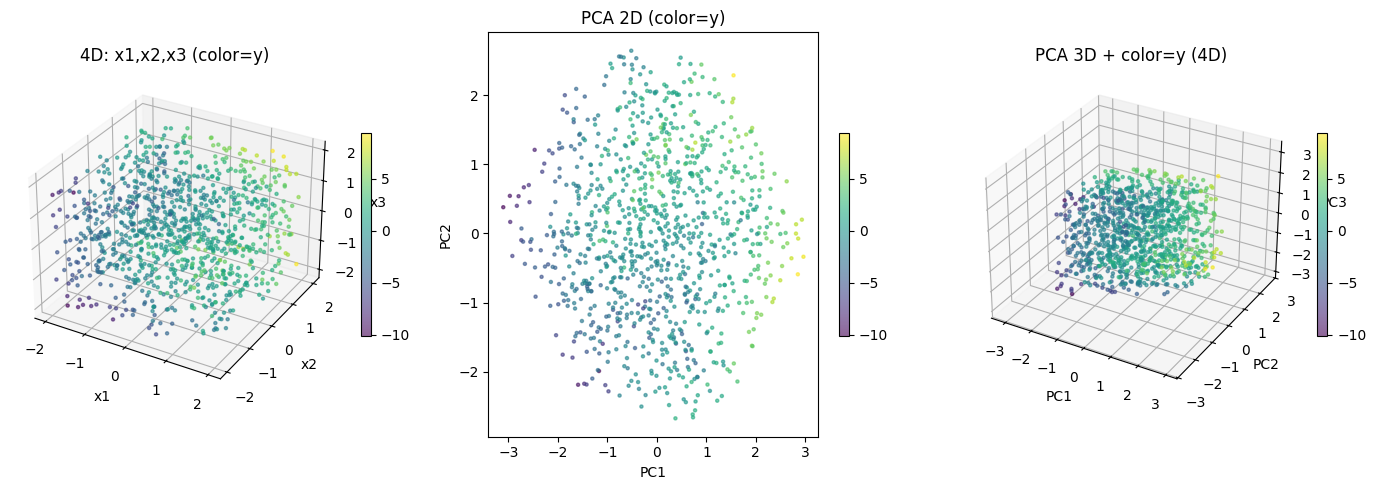

In [3]:
# ============================================================
# Section 3: 4D Data Visualization
# ============================================================
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_zlabel('x3')
ax1.set_title('4D: x1,x2,x3 (color=y)')
plt.colorbar(sc1, ax=ax1, shrink=0.5)

pca2 = PCA(n_components=2)
Xp2 = pca2.fit_transform(X)
ax2 = fig.add_subplot(132)
sc2 = ax2.scatter(Xp2[:, 0], Xp2[:, 1], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2')
ax2.set_title('PCA 2D (color=y)')
plt.colorbar(sc2, ax=ax2, shrink=0.5)

pca3 = PCA(n_components=3)
Xp3 = pca3.fit_transform(X)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(Xp3[:, 0], Xp3[:, 1], Xp3[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax3.set_xlabel('PC1'); ax3.set_ylabel('PC2'); ax3.set_zlabel('PC3')
ax3.set_title('PCA 3D + color=y (4D)')
plt.colorbar(sc3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

In [4]:
# ============================================================
# Section 4: Define Neural Network Class (nn.Module)
# ============================================================

class ThreeLayerDNN(nn.Module):
    """
    3-Hidden-Layer Deep Neural Network for Non-Linear Regression.

    Architecture:
        Input(3) -> Linear(64) -> ReLU -> Linear(32) -> ReLU
        -> Linear(16) -> ReLU -> Linear(1)

    Uses:
        - nn.Linear for fully connected layers
        - nn.ReLU for activation functions
        - He/Kaiming initialization for weights
    """

    def __init__(self, input_dim=3, h1=64, h2=32, h3=16, output_dim=1):
        super(ThreeLayerDNN, self).__init__()

        # Define layers
        self.layer1 = nn.Linear(input_dim, h1)
        self.layer2 = nn.Linear(h1, h2)
        self.layer3 = nn.Linear(h2, h3)
        self.output_layer = nn.Linear(h3, output_dim)

        # Activation
        self.relu = nn.ReLU()

        # Apply He initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Apply Kaiming (He) initialization to all linear layers."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                nn.init.zeros_(module.bias)

    def forward(self, x):
        """Forward pass through the network."""
        x = self.relu(self.layer1(x))   # Hidden Layer 1
        x = self.relu(self.layer2(x))   # Hidden Layer 2
        x = self.relu(self.layer3(x))   # Hidden Layer 3
        x = self.output_layer(x)         # Output Layer (linear)
        return x

# Create model
model = ThreeLayerDNN().to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

ThreeLayerDNN(
  (layer1): Linear(in_features=3, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

Total parameters: 2881
Trainable parameters: 2881


In [5]:
# ============================================================
# Section 5: Loss Function and Optimizer
# ============================================================

criterion = nn.MSELoss()  # Built-in MSE loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=50
)

print(f"Loss: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=50)")

Loss: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=50)


In [6]:
# ============================================================
# Section 6: Training Loop (Using Built-in PyTorch)
# ============================================================

EPOCHS = 500
train_losses = []
test_losses = []

print(f"Training for {EPOCHS} epochs...")
print("=" * 60)

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    epoch_loss = 0.0
    n_batches = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients (backprop)
        optimizer.step()       # Update weights

        epoch_loss += loss.item()
        n_batches += 1

    avg_train_loss = epoch_loss / n_batches
    train_losses.append(avg_train_loss)

    # --- Evaluation Phase ---
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        n_test = 0
        for X_b, y_b in test_loader:
            X_b, y_b = X_b.to(device), y_b.to(device)
            pred = model(X_b)
            test_loss += criterion(pred, y_b).item()
            n_test += 1
        avg_test_loss = test_loss / n_test
        test_losses.append(avg_test_loss)

    # Learning rate scheduling
    scheduler.step(avg_test_loss)

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:4d}/{EPOCHS}] | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

print("=" * 60)
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss:  {test_losses[-1]:.6f}")

Training for 500 epochs...
Epoch [   1/500] | Train Loss: 1.212840 | Test Loss: 0.806027
Epoch [  50/500] | Train Loss: 0.031200 | Test Loss: 0.037908
Epoch [ 100/500] | Train Loss: 0.014795 | Test Loss: 0.018242
Epoch [ 150/500] | Train Loss: 0.006234 | Test Loss: 0.009019
Epoch [ 200/500] | Train Loss: 0.003970 | Test Loss: 0.006466
Epoch [ 250/500] | Train Loss: 0.002207 | Test Loss: 0.004429
Epoch [ 300/500] | Train Loss: 0.001964 | Test Loss: 0.005053
Epoch [ 350/500] | Train Loss: 0.004135 | Test Loss: 0.007538
Epoch [ 400/500] | Train Loss: 0.001650 | Test Loss: 0.004878
Epoch [ 450/500] | Train Loss: 0.001204 | Test Loss: 0.003852
Epoch [ 500/500] | Train Loss: 0.001614 | Test Loss: 0.004081
Final Train Loss: 0.001614
Final Test Loss:  0.004081


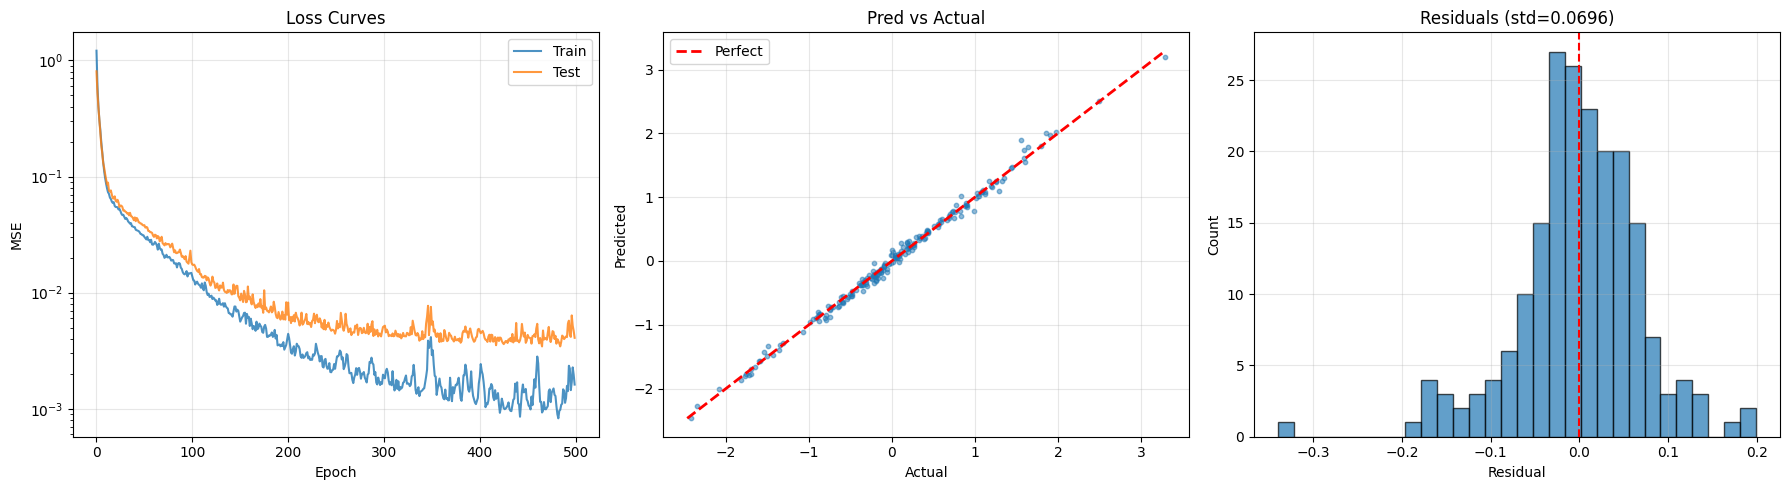

R-squared: 0.994093
MAE: 0.050952


In [7]:
# ============================================================
# Section 7: Results Visualization
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
axes[0].plot(train_losses, label='Train', alpha=0.8)
axes[0].plot(test_losses, label='Test', alpha=0.8)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE')
axes[0].set_title('Loss Curves'); axes[0].legend()
axes[0].set_yscale('log'); axes[0].grid(True, alpha=0.3)

# Predictions
model.eval()
with torch.no_grad():
    y_final = model(X_test_t.to(device)).cpu().numpy()
y_actual = y_test_t.numpy()

axes[1].scatter(y_actual, y_final, alpha=0.5, s=10)
mn, mx = min(y_actual.min(), y_final.min()), max(y_actual.max(), y_final.max())
axes[1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect')
axes[1].set_xlabel('Actual'); axes[1].set_ylabel('Predicted')
axes[1].set_title('Pred vs Actual'); axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Residuals
res = (y_actual - y_final).flatten()
axes[2].hist(res, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='r', linestyle='--')
axes[2].set_xlabel('Residual'); axes[2].set_ylabel('Count')
axes[2].set_title(f'Residuals (std={res.std():.4f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

r2 = 1 - np.sum((y_actual - y_final)**2) / np.sum((y_actual - y_actual.mean())**2)
print(f"R-squared: {r2:.6f}")
print(f"MAE: {np.mean(np.abs(res)):.6f}")

In [8]:
# ============================================================
# Section 8: Model Summary & Sample Predictions
# ============================================================

# Denormalize
y_test_orig = y_actual * y_std + y_mean
y_pred_orig = y_final * y_std + y_mean
X_test_orig = X_test_t.numpy() * X_std + X_mean

print("Sample Predictions (Original Scale):")
print("=" * 70)
print(f"{'Idx':>5} | {'x1':>7} | {'x2':>7} | {'x3':>7} | {'Actual':>9} | {'Predicted':>9} | {'Error':>7}")
print("-" * 70)
for i in range(15):
    a, p = y_test_orig[i,0], y_pred_orig[i,0]
    print(f"{i:5d} | {X_test_orig[i,0]:7.3f} | {X_test_orig[i,1]:7.3f} | {X_test_orig[i,2]:7.3f} | {a:9.4f} | {p:9.4f} | {abs(a-p):7.4f}")

print(f"\nRMSE: {np.sqrt(np.mean((y_test_orig-y_pred_orig)**2)):.4f}")
print(f"R²: {r2:.6f}")

print("\n=== Colab C Complete ===")
print("Key points:")
print("- Used nn.Module class-based architecture")
print("- nn.Linear layers with He initialization")
print("- Adam optimizer with LR scheduler")
print("- DataLoader for mini-batch training")
print("- Built-in loss.backward() for backpropagation")

Sample Predictions (Original Scale):
  Idx |      x1 |      x2 |      x3 |    Actual | Predicted |   Error
----------------------------------------------------------------------
    0 |   0.829 |   1.826 |   1.170 |    5.2825 |    5.7168 |  0.4343
    1 |  -1.390 |   0.950 |   1.632 |    1.7257 |    1.9005 |  0.1748
    2 |   0.305 |  -0.587 |   1.775 |   -1.8073 |   -1.8080 |  0.0007
    3 |   0.427 |  -0.814 |   1.841 |   -2.5965 |   -2.5240 |  0.0726
    4 |  -0.303 |  -0.601 |   0.086 |   -0.4148 |   -0.5336 |  0.1188
    5 |   0.946 |   1.099 |   1.909 |    4.6694 |    5.0841 |  0.4147
    6 |   1.737 |   0.645 |   1.029 |    1.9903 |    2.0920 |  0.1018
    7 |   1.702 |  -1.259 |  -1.353 |   -0.3670 |   -0.5368 |  0.1698
    8 |  -0.197 |  -1.304 |  -0.092 |   -0.5389 |   -0.8354 |  0.2965
    9 |  -1.547 |  -1.606 |   0.873 |   -4.7987 |   -4.7877 |  0.0110
   10 |   1.939 |   0.641 |  -1.011 |    2.0689 |    2.1786 |  0.1097
   11 |   1.356 |   1.057 |   0.562 |    2.5738 |   